In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('X_val.npy')
y=np.load('y_val.npy')

In [3]:
from keras import layers, models
from keras.models import load_model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def model_load(model):
    model = load_model(model,compile=False)
    model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4), 
            metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])
    
    return model

Using TensorFlow backend.


In [4]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [5]:
#ensemble할 model load

model1=model_load('./G_팔로미_models/VGG16_1_no callback(541).hdf5')
model2=model_load('./G_팔로미_models/VGG16_fine_tuning_2(623)_no callback.hdf5')
model3=model_load('./G_팔로미_models/Inception v3_fine tuning_2(613).hdf5')

members = [model1, model2, model3]

In [6]:
# stacked generalization with neural net meta model on blobs dataset
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

In [21]:
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unuque layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name

    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.input for model in members]
    
    for layer in model.layers:
            # make not trainable
            layer.trainable = False
            
    x = concatenate(ensemble_outputs)
    x=layers.Flatten()(x)
    #hidden = Dense(9, activation = 'relu')(flatten)
    output = Dense(4, activation = 'softmax')(x)
    model = Model(inputs=ensemble_visible, outputs=output)

    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [28]:
# define ensemble model
stacked_model = define_stacked_model(members)

In [29]:
stacked_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
ensemble_2_ensemble_2_ensemble_ (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
ensemble_3_ensemble_3_ensemble_ (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 224, 224, 9)  0           vgg16_input[0][0]                
                                                                 ensemble_2_ensemble_2_ensem

In [30]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='model_stacking.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [31]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # encode output data
    # fir model
    model.fit(X, inputy, epochs=300, callbacks=[checkpoint])

In [32]:
# fit stacked model on test dataset
fit_stacked_model(stacked_model, X, y)

Epoch 1/300
571/571 [==============================] - 2s 3ms/step - loss: 115.0517 - accuracy: 0.2680
Epoch 2/300
571/571 [==============================] - 2s 3ms/step - loss: 35.3957 - accuracy: 0.3345
Epoch 3/300
571/571 [==============================] - 2s 3ms/step - loss: 19.5085 - accuracy: 0.4431
Epoch 4/300
571/571 [==============================] - 2s 3ms/step - loss: 20.2197 - accuracy: 0.4028
Epoch 5/300
571/571 [==============================] - 2s 3ms/step - loss: 28.6315 - accuracy: 0.3730
Epoch 6/300
571/571 [==============================] - 2s 3ms/step - loss: 28.2006 - accuracy: 0.3415
Epoch 7/300
571/571 [==============================] - 2s 3ms/step - loss: 23.9146 - accuracy: 0.3713
Epoch 8/300
571/571 [==============================] - 2s 3ms/step - loss: 43.3967 - accuracy: 0.3678
Epoch 9/300
571/571 [==============================] - 2s 3ms/step - loss: 15.4681 - accuracy: 0.4378
Epoch 10/300
571/571 [==============================] - 2s 3ms/step - loss: 24.26

571/571 [==============================] - 2s 3ms/step - loss: 14.1705 - accuracy: 0.5727
Epoch 81/300
571/571 [==============================] - 2s 3ms/step - loss: 17.2422 - accuracy: 0.5061
Epoch 82/300
571/571 [==============================] - 2s 3ms/step - loss: 16.9936 - accuracy: 0.5517
Epoch 83/300
571/571 [==============================] - 2s 3ms/step - loss: 9.0052 - accuracy: 0.6725
Epoch 84/300
571/571 [==============================] - 2s 3ms/step - loss: 11.3490 - accuracy: 0.6357
Epoch 85/300
571/571 [==============================] - 2s 3ms/step - loss: 16.1248 - accuracy: 0.5517
Epoch 86/300
571/571 [==============================] - 2s 3ms/step - loss: 8.8049 - accuracy: 0.6270
Epoch 87/300
571/571 [==============================] - 2s 3ms/step - loss: 8.7892 - accuracy: 0.6305
Epoch 88/300
571/571 [==============================] - 2s 3ms/step - loss: 11.2961 - accuracy: 0.6042
Epoch 89/300
571/571 [==============================] - 2s 3ms/step - loss: 11.2477 - acc

571/571 [==============================] - 2s 3ms/step - loss: 3.4949 - accuracy: 0.7863
Epoch 159/300
571/571 [==============================] - 2s 3ms/step - loss: 7.1425 - accuracy: 0.7285
Epoch 160/300
571/571 [==============================] - 2s 3ms/step - loss: 8.8910 - accuracy: 0.6743
Epoch 161/300
571/571 [==============================] - 2s 3ms/step - loss: 7.7215 - accuracy: 0.6883
Epoch 162/300
571/571 [==============================] - 2s 3ms/step - loss: 16.2704 - accuracy: 0.5727
Epoch 163/300
571/571 [==============================] - 2s 3ms/step - loss: 15.9330 - accuracy: 0.6305
Epoch 164/300
571/571 [==============================] - 2s 3ms/step - loss: 21.5144 - accuracy: 0.5797
Epoch 165/300
571/571 [==============================] - 2s 3ms/step - loss: 11.4792 - accuracy: 0.6427
Epoch 166/300
571/571 [==============================] - 2s 3ms/step - loss: 11.5682 - accuracy: 0.6585
Epoch 167/300
571/571 [==============================] - 2s 3ms/step - loss: 16.73

571/571 [==============================] - 2s 3ms/step - loss: 8.4477 - accuracy: 0.7356
Epoch 238/300
571/571 [==============================] - 2s 3ms/step - loss: 10.9853 - accuracy: 0.6935
Epoch 239/300
571/571 [==============================] - 2s 3ms/step - loss: 9.8510 - accuracy: 0.6865
Epoch 240/300
571/571 [==============================] - 2s 3ms/step - loss: 7.1962 - accuracy: 0.7601
Epoch 241/300
571/571 [==============================] - 2s 3ms/step - loss: 6.1477 - accuracy: 0.7758
Epoch 242/300
571/571 [==============================] - 2s 3ms/step - loss: 5.3193 - accuracy: 0.7793
Epoch 243/300
571/571 [==============================] - 2s 3ms/step - loss: 6.5622 - accuracy: 0.7285
Epoch 244/300
571/571 [==============================] - 2s 3ms/step - loss: 4.9348 - accuracy: 0.7846
Epoch 245/300
571/571 [==============================] - 2s 3ms/step - loss: 7.0225 - accuracy: 0.7443
Epoch 246/300
571/571 [==============================] - 2s 3ms/step - loss: 13.9663 -

In [33]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X)

In [34]:
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X)

y_label=np.argmax(y,axis=1)
predict=np.argmax(yhat,axis=1)


acc = accuracy_score(y_label, predict)
print('Stacked Test Accracy : %.3f' % acc)

Stacked Test Accracy : 0.891


In [36]:
#AUC 출력하기
from sklearn.metrics import roc_curve, roc_auc_score, auc

roc_auc_score(y, yhat)

0.9894989314025899

In [37]:
from sklearn.metrics import confusion_matrix

matrix =confusion_matrix(y_label, predict)

matrix

array([[118,   1,  16,   0],
       [  9, 103,  21,   3],
       [  1,   0, 128,   0],
       [  1,   0,  10, 160]], dtype=int64)

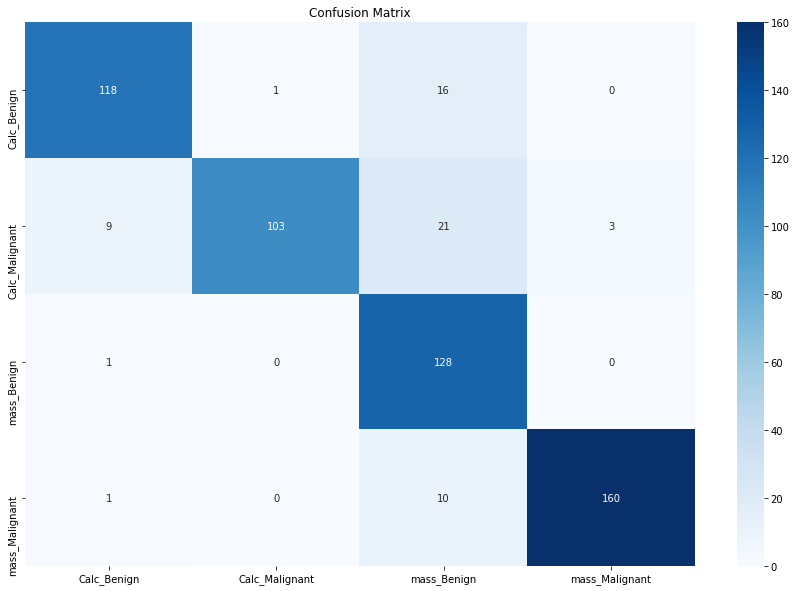

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


index = ['Calc_Benign','Calc_Malignant','mass_Benign','mass_Malignant']  
columns = ['Calc_Benign','Calc_Malignant','mass_Benign','mass_Malignant']  
cm_df = pd.DataFrame(matrix,columns,index)                      
plt.figure(figsize=(15,10)) 
plt.title("Confusion Matrix")
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')